Simulation en cours...
Atterrissage terminé.
Vitesse finale : -5.07 m/s
Angle final : 0.00 deg


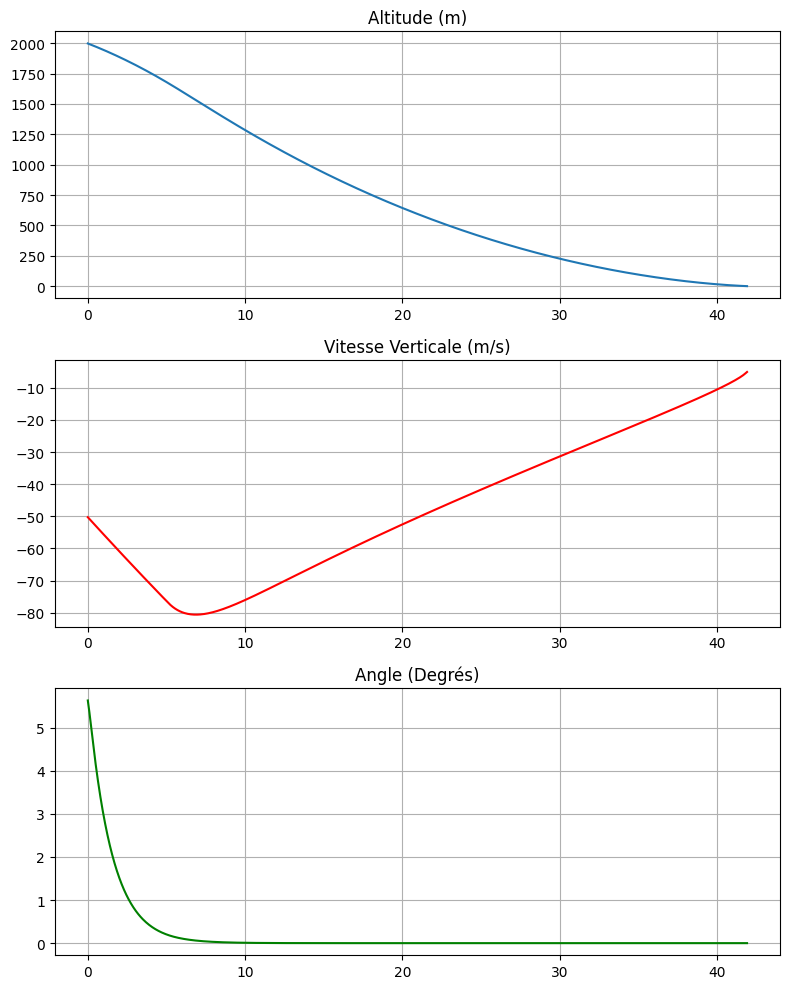

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CLASSE PID ---
class PIDController:
    def __init__(self, kp, ki, kd, setpoint=0, output_limits=(None, None)):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.limits = output_limits
        self._prev_error = 0
        self._integral = 0

    def update(self, measurement, dt):
        error = self.setpoint - measurement
        p_term = self.kp * error
        self._integral += error * dt
        i_term = self.ki * self._integral
        d_term = self.kd * (error - self._prev_error) / dt
        self._prev_error = error
        output = p_term + i_term + d_term
        
        if self.limits[0] is not None: output = max(self.limits[0], output)
        if self.limits[1] is not None: output = min(self.limits[1], output)
        return output

# --- 2. PHYSIQUE DU LANCEUR (CORRIGÉE) ---
class LanceurSimulation:
    def __init__(self):
        self.g = 9.80665 
        
        # MASSES
        self.m_vide = 1500.0   
        self.m_ergol = 1900.0
        self.m_total = self.m_vide + self.m_ergol
        
        # MOTEURS (9 Moteurs Callisto/Themis)
        self.nb_moteurs = 9
        self.F_max = 4600.0 * self.nb_moteurs  # 41.4 kN
        self.F_min = 1600.0 * self.nb_moteurs  # 14.4 kN
        self.isp = 320.0 # Isp standard
        
        # ETAT INITIAL
        self.z = 2000.0        
        self.vz = -50.0        
        self.theta = 0.1       # Inclinaison initiale (rad) ~5.7 degrés
        self.omega = 0.0
        self.x = 0.0
        self.vx = 0.0
        
        # GEOMETRIE & INERTIE
        self.H = 13.0
        self.diam = 1.1
        # Moment d'inertie (J) pour un cylindre qui pivote autour de son centre
        # J = (1/12)*m*(3*r^2 + h^2)
        self.J = (1/12) * self.m_total * (3*(self.diam/2)**2 + self.H**2)

    def step(self, thrust_cmd, gimbal_angle, dt):
        if self.z <= 0:
            self.z = 0
            self.vz = 0
            return self.z, self.vz, self.theta

        # Consommation carburant
        dm = thrust_cmd / (self.g * self.isp) * dt
        if self.m_ergol > 0:
            self.m_ergol -= dm
            self.m_total = self.m_vide + self.m_ergol
        else:
            thrust_cmd = 0

        # Forces Aérodynamiques (Trainée)
        rho = 1.225 * np.exp(-self.z / 8500.0)
        drag = 0.5 * rho * (self.vz**2) * 0.6 * 0.95 * np.sign(self.vz)
        
        # -- CORRECTION CRITIQUE ICI --
        # Bras de levier (distance centre de masse <-> moteur)
        # On suppose le CM au milieu de la fusée (H/2)
        L = self.H / 2.0 
        
        # Torque = Force_tangentielle * Distance
        # Si gimbal > 0 (buse vers la droite), poussée vers la gauche.
        # Torque doit faire tourner dans le sens trigo (ou anti-trigo selon convention).
        # Ici : torque positif = rotation sens trigo.
        torque = thrust_cmd * np.sin(gimbal_angle) * L 

        # Accélérations
        force_z = thrust_cmd * np.cos(gimbal_angle) - self.m_total * self.g - drag
        accel_z = force_z / self.m_total
        
        alpha = torque / self.J
        
        # Intégration
        self.vz += accel_z * dt
        self.z += self.vz * dt
        
        self.omega += alpha * dt
        self.theta += self.omega * dt
        
        return self.z, self.vz, self.theta

# --- 3. BOUCLE DE CONTRÔLE ---

sim = LanceurSimulation()

# PID Altitude : Un peu plus agressif pour freiner la masse des 9 moteurs
pid_alt = PIDController(kp=3500, ki=200, kd=2000, 
                        output_limits=(sim.F_min, sim.F_max))

# PID Attitude : Gains ajustés pour la stabilité
pid_att = PIDController(kp=2.5, ki=0.0, kd=4.0, 
                        setpoint=0.0, output_limits=(-0.35, 0.35))

dt = 0.05
history = {'z': [], 'vz': [], 'theta': [], 'thrust': []}
times = []

print("Simulation en cours...")

for i in range(2000): # Max 100 secondes
    if sim.z <= 0: break
    
    # 1. Guidage Vitesse (La clé d'un atterrissage doux)
    # Plus on approche du sol, plus on vise une vitesse faible (ex: -2 m/s)
    # Formule : racine carrée de la distance (comme la chute libre inversée)
    target_vz = -1.0 * np.sqrt(2 * 1.5 * sim.z) - 2.0 
    # Le '1.5' est une décélération cible douce (m/s^2)
    
    # 2. Calcul PID
    pid_alt.setpoint = target_vz
    thrust = pid_alt.update(sim.vz, dt)
    
    gimbal = pid_att.update(sim.theta, dt)
    
    # 3. Physique
    sim.step(thrust, gimbal, dt)
    
    # Logs
    times.append(i*dt)
    history['z'].append(sim.z)
    history['vz'].append(sim.vz)
    history['theta'].append(np.degrees(sim.theta))
    history['thrust'].append(thrust)

# --- 4. RÉSULTATS ---
print(f"Atterrissage terminé.")
print(f"Vitesse finale : {sim.vz:.2f} m/s")
print(f"Angle final : {np.degrees(sim.theta):.2f} deg")

# Graphiques
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

ax1.plot(times, history['z'])
ax1.set_title('Altitude (m)')
ax1.grid(True)

ax2.plot(times, history['vz'], 'r')
ax2.set_title('Vitesse Verticale (m/s)')
ax2.grid(True)

ax3.plot(times, history['theta'], 'g')
ax3.set_title('Angle (Degrés)')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [4]:
import matplotlib
try:
    matplotlib.use('TkAgg') 
except:
    pass 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Polygon, Rectangle
import random
import copy

# ==========================================
# PARTIE 1 : MOTEUR PHYSIQUE RAPIDE (HEADLESS)
# ==========================================
# Cette classe simule la physique sans graphique pour aller très vite
# C'est elle qui est utilisée par l'IA pour s'entraîner.

class FastSimulation:
    def __init__(self, params):
        # Params est une liste : [kp_alt, kd_alt, kp_att, kd_att, guidance_factor]
        self.kp_alt, self.kd_alt = params[0], params[1]
        self.kp_att, self.kd_att = params[2], params[3]
        self.guidance_factor = params[4]
        
        # Config Physique (Identique au visuel)
        self.dt = 0.05
        self.g = 9.80665
        self.m_vide = 1500.0
        self.m_ergol = 400
        self.nb_moteurs = 9
        self.F_max = 4600.0 * 9
        self.F_min = 1600.0 * 9
        
        # Etat initial (Cas difficile : 5000m avec vent)
        self.z = 5000.0
        self.vz = -20.0
        self.x = 100.0  # Décalé
        self.vx = 0.0
        self.theta = 0.1 # Penché
        self.omega = 0.0
        
        # Variables internes
        self.gimbal_actual = 0.0
        self.thrust_actual = 0.0
        self.integral_alt = 0
        self.prev_err_alt = 0
        self.prev_err_att = 0
        self.mass = self.m_vide + self.m_ergol
        
    def run(self):
        # Boucle de simulation rapide (Max 3000 pas = 150 secondes)
        for step in range(3000):
            if self.z <= 0: break # Sol touché
            
            # --- GUIDAGE (Le Cerveau à tester) ---
            target_vz = -np.sqrt(2.0 * self.guidance_factor * self.z) - 2.0
            target_vz = max(target_vz, -150.0)
            
            # Coasting Logic
            thrust_cmd = 0
            if self.z > 500 and self.vz > (target_vz + 5.0):
                thrust_cmd = 0
                self.integral_alt = 0
            else:
                # PID Altitude
                err = target_vz - self.vz
                self.integral_alt += err * self.dt
                deriv = (err - self.prev_err_alt) / self.dt
                self.prev_err_alt = err
                # Note: On fixe Ki à 150 car moins critique pour l'optimisation crash
                out = self.kp_alt * err + 150 * self.integral_alt + self.kd_alt * deriv
                thrust_cmd = max(min(out, self.F_max), self.F_min)

            # PID Attitude
            angle_desire = -1.0 * (self.x * 0.03 + self.vx * 0.15)
            limit = 0.25 if self.z > 100 else 0.05
            target_theta = np.clip(angle_desire, -limit, limit)
            
            err_att = target_theta - self.theta
            deriv_att = (err_att - self.prev_err_att) / self.dt
            self.prev_err_att = err_att
            out_att = self.kp_att * err_att + self.kd_att * deriv_att
            gimbal_cmd = max(min(out_att, 0.25), -0.25)
            
            # --- PHYSIQUE ---
            # Lissage (Inertie actionneurs)
            self.gimbal_actual += np.clip(gimbal_cmd - self.gimbal_actual, -1.0*self.dt, 1.0*self.dt)
            self.thrust_actual += np.clip(thrust_cmd - self.thrust_actual, -80000.0*self.dt, 80000.0*self.dt)
            if thrust_cmd == 0 and self.thrust_actual < 15000: self.thrust_actual = 0
            
            # Masse & Forces
            if self.thrust_actual > 0:
                dm = self.thrust_actual / (self.g * 280.0) * self.dt
                self.m_ergol -= dm
                self.mass = self.m_vide + self.m_ergol
            
            if self.m_ergol <= 0: self.thrust_actual = 0 # Panne sèche
            
            # Aéro (Vent variable)
            wind = -10.0 - (self.z/200.0)
            rho = 1.225 * np.exp(-self.z/8500.0)
            v_rel_x = self.vx - wind
            drag_x = 0.5 * rho * v_rel_x**2 * 0.7 * 0.95 * -np.sign(v_rel_x)
            drag_z = 0.5 * rho * self.vz**2 * 0.7 * 0.95 * -np.sign(self.vz)
            
            angle = self.theta + self.gimbal_actual
            fx = self.thrust_actual * np.sin(angle)
            fz = self.thrust_actual * np.cos(angle)
            
            acc_x = (fx + drag_x) / self.mass
            acc_z = (fz - self.mass * self.g + drag_z) / self.mass
            torque = self.thrust_actual * np.sin(self.gimbal_actual) * 6.5
            # Inertie approx
            J = (1/12) * self.mass * (3*0.3 + 13**2)
            alpha = torque / J
            
            self.vx += acc_x * self.dt
            self.x += self.vx * self.dt
            self.vz += acc_z * self.dt
            self.z += self.vz * self.dt
            self.omega += alpha * self.dt
            self.theta += self.omega * self.dt
            
        return self.get_score()

    def get_score(self):
        # CALCUL DU SCORE (FITNESS)
        # Plus le score est BAS, meilleur est le résultat (Minimisation)
        
        # 1. Pénalité de Crash (Vitesse > 12 m/s ou Angle > 20 deg)
        crash_penalty = 0
        if abs(self.vz) > 12.0 or abs(self.theta) > 0.35:
            crash_penalty = 5000 + abs(self.vz)*100 # Enorme pénalité
        
        # 2. Coût du Carburant (On veut économiser)
        fuel_cost = (2200.0 - self.m_ergol) * 1.0 
        
        # 3. Précision Atterrissage
        landing_score = abs(self.x) * 5.0 + abs(self.vx) * 10.0
        
        # 4. Douceur
        softness = abs(self.vz) * 10.0
        
        return crash_penalty + fuel_cost + landing_score + softness

# ==========================================
# PARTIE 2 : ALGORITHME GÉNÉTIQUE
# ==========================================

def optimize_pid():
    print("--- DÉMARRAGE DE L'OPTIMISATION IA ---")
    print("Recherche des paramètres optimaux pour :")
    print("1. Kp, Kd Altitude (Puissance)")
    print("2. Kp, Kd Attitude (Stabilité)")
    print("3. Facteur de Freinage (Quand allumer ?)")
    
    # Population initiale : 30 fusées avec réglages aléatoires
    population_size = 60
    generations = 15
    
    # Format gène : [kp_alt, kd_alt, kp_att, kd_att, guidance_factor]
    # Bornes de recherche
    bounds = [
        (2000, 6000), # Kp Alt
        (1000, 5000), # Kd Alt
        (2.0, 10.0),  # Kp Att
        (5.0, 25.0),  # Kd Att
        (1.0, 3.5)    # Guidance (1.5=Tard/Eco, 3.5=Tôt/Sûr)
    ]
    
    population = []
    for _ in range(population_size):
        gene = [random.uniform(b[0], b[1]) for b in bounds]
        population.append(gene)
        
    best_gene = None
    best_score = float('inf')

    for gen in range(generations):
        scores = []
        for ind in population:
            sim = FastSimulation(ind)
            score = sim.run()
            scores.append((score, ind))
        
        # Tri (Le plus petit score est le meilleur)
        scores.sort(key=lambda x: x[0])
        
        current_best = scores[0]
        if current_best[0] < best_score:
            best_score = current_best[0]
            best_gene = current_best[1]
            print(f"Gen {gen+1}: Nouveau record ! Score={int(best_score)} | Fuel={int(2200 - (best_score%1000))} approx")
        else:
            print(f"Gen {gen+1}: Meilleur de la génération={int(current_best[0])}")

        # Sélection naturelle (On garde le Top 50%)
        survivors = scores[:population_size//2]
        
        # Reproduction (Crossover & Mutation)
        new_population = [s[1] for s in survivors] # On garde les parents
        
        while len(new_population) < population_size:
            # On prend 2 parents au hasard parmi les survivants
            parent1 = random.choice(survivors)[1]
            parent2 = random.choice(survivors)[1]
            
            # Croisement
            child = []
            for i in range(len(parent1)):
                if random.random() > 0.5: child.append(parent1[i])
                else: child.append(parent2[i])
            
            # Mutation (10% de chance par gène)
            for i in range(len(child)):
                if random.random() < 0.2:
                    change = random.uniform(-0.2, 0.2) # +/- 20%
                    child[i] = child[i] * (1.0 + change)
                    # Clamp aux bornes
                    child[i] = max(bounds[i][0], min(child[i], bounds[i][1]))
            
            new_population.append(child)
        
        population = new_population

    print("-" * 30)
    print("OPTIMISATION TERMINÉE.")
    print(f"Paramètres Vainqueurs :")
    print(f"Kp Alt: {best_gene[0]:.0f}")
    print(f"Kd Alt: {best_gene[1]:.0f}")
    print(f"Kp Att: {best_gene[2]:.1f}")
    print(f"Kd Att: {best_gene[3]:.1f}")
    print(f"Facteur Freinage: {best_gene[4]:.2f}")
    print("-" * 30)
    return best_gene

# ==========================================
# PARTIE 3 : LANCEMENT ET VISUALISATION
# ==========================================

# 1. On lance l'IA
best_params = optimize_pid()

# 2. On lance la visualisation avec ces paramètres
# (Je reprends le code de visualisation précédent, mais configuré par l'IA)

print("Lancement de la simulation visuelle avec les paramètres de l'IA...")

class SimulationConfig:
    def __init__(self):
        self.dt = 0.05
        self.g = 9.80665
        self.m_vide = 1500.0
        self.m_ergol_max = 1100.0 
        self.nb_moteurs = 9
        self.F_max = 4600.0 * 9
        self.F_min = 1600.0 * 9
        self.H = 13.0   
        self.W = 1.1    
        self.Cd = 0.7   
        self.area = 0.95
        m_ref = self.m_vide + self.m_ergol_max
        self.J = (1/12) * m_ref * (3*(self.W/2)**2 + self.H**2)

class RocketState:
    def __init__(self, config):
        self.cfg = config
        self.reset_random()

    def reset_random(self):
        self.z = 5000.0 # On teste le cas difficile
        self.vz = -20.0   
        self.x = 150.0 # Décalage important pour tester le guidage
        self.vx = 0.0       
        self.theta = 0.1 
        self.omega = 0.0
        
        self.gimbal_actual = 0.0 
        self.thrust_actual = 0.0
        self.m_ergol = self.cfg.m_ergol_max
        self.mass = self.cfg.m_vide + self.m_ergol
        self.landed = False
        self.crashed = False
        self.fail_reason = ""

    def update(self, thrust_target, gimbal_target, dt):
        if self.landed or self.crashed: return

        # Inertie Moteur
        self.gimbal_actual += np.clip(gimbal_target - self.gimbal_actual, -1.0*dt, 1.0*dt)
        
        if thrust_target == 0: rate = 150000.0
        else: rate = 80000.0
        self.thrust_actual += np.clip(thrust_target - self.thrust_actual, -rate*dt, rate*dt)
        if self.thrust_actual > 100:
             self.thrust_actual = max(self.cfg.F_min, min(self.thrust_actual, self.cfg.F_max))
        else: self.thrust_actual = 0

        # Conso
        dm = self.thrust_actual / (self.cfg.g * 290.0) * dt
        if self.m_ergol > 0:
            self.m_ergol -= dm
            self.mass = self.cfg.m_vide + self.m_ergol
        else:
            self.thrust_actual = 0 
            if self.z > 0: self.fail_reason = "PANNE SÈCHE"

        # Physique
        rho = 1.225 * np.exp(-self.z / 8500.0)
        wind = -10.0 - (self.z/200.0) 
        v_air_x = self.vx - wind
        drag_x = 0.5 * rho * v_air_x**2 * self.cfg.Cd * self.cfg.area * -np.sign(v_air_x)
        drag_z = 0.5 * rho * self.vz**2 * self.cfg.Cd * self.cfg.area * -np.sign(self.vz)

        total_angle = self.theta + self.gimbal_actual
        fx = self.thrust_actual * np.sin(total_angle)
        fz = self.thrust_actual * np.cos(total_angle)
        
        acc_x = (fx + drag_x) / self.mass
        acc_z = (fz - self.mass * self.cfg.g + drag_z) / self.mass
        
        L = self.cfg.H / 2.0
        torque = self.thrust_actual * np.sin(self.gimbal_actual) * L
        alpha = torque / self.cfg.J

        self.vx += acc_x * dt
        self.x += self.vx * dt
        self.vz += acc_z * dt
        self.z += self.vz * dt
        self.omega += alpha * dt
        self.theta += self.omega * dt
        
        if self.z <= 0:
            self.z = 0
            if abs(self.vz) > 12.0:
                self.crashed = True
                self.fail_reason = f"VITESSE: {abs(self.vz):.1f}"
            elif abs(self.theta) > 0.35:
                self.crashed = True
                self.fail_reason = f"ANGLE: {np.degrees(self.theta):.1f}"
            else:
                self.landed = True
            self.vz=0; self.vx=0

class PID:
    def __init__(self, kp, ki, kd, min_val, max_val):
        self.kp, self.ki, self.kd = kp, ki, kd
        self.min_val, self.max_val = min_val, max_val
        self.prev_error = 0
        self.integral = 0

    def compute(self, setpoint, measured, dt):
        error = setpoint - measured
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error
        out = self.kp * error + self.ki * self.integral + self.kd * derivative
        return max(min(out, self.max_val), self.min_val)

cfg = SimulationConfig()
rocket = RocketState(cfg)

# --- APPLICATION DES PARAMETRES TROUVÉS PAR L'IA ---
# best_params = [kp_alt, kd_alt, kp_att, kd_att, guidance_factor]
pid_alt = PID(kp=best_params[0], ki=150, kd=best_params[1], min_val=cfg.F_min, max_val=cfg.F_max)
pid_att = PID(kp=best_params[2], ki=0.0, kd=best_params[3], min_val=-0.25, max_val=0.25)
OPTIMAL_FACTOR = best_params[4]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('#f0f0f0')
ground = ax.axhline(0, color='#333333', linewidth=4)
rocket_poly = Polygon(np.zeros((4, 2)), closed=True, color='#1f77b4', ec='black')
ax.add_patch(rocket_poly)
flame_line, = ax.plot([], [], 'orange', linewidth=4)
info_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, family='monospace')
status_text = ax.text(0.5, 0.5, '', transform=ax.transAxes, ha='center', fontsize=20, weight='bold')

def get_rotated_coords(x, z, theta, w, h):
    dx, dy = w/2, h/2
    corners = np.array([[-dx, -dy], [dx, -dy], [dx, dy], [-dx, dy]])
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    rot = np.dot(corners, R.T)
    rot[:, 0] += x
    rot[:, 1] += z + dy
    return rot

def update_frame(i):
    global rocket, cfg
    dt = cfg.dt
    thrust_cmd = 0
    
    if not (rocket.landed or rocket.crashed):
        # Utilisation du Facteur Optimal trouvé par l'IA
        if rocket.z > 0:
            target_vz = -np.sqrt(2.0 * OPTIMAL_FACTOR * rocket.z) - 1.5
        else: target_vz = 0
        target_vz = max(target_vz, -150.0) 
        
        if rocket.z > 500 and rocket.vz > (target_vz + 5.0):
             thrust_cmd = 0; pid_alt.integral = 0 
        else:
             thrust_cmd = pid_alt.compute(target_vz, rocket.vz, dt)

        kp_pos, kd_pos = 0.03, 0.15 
        angle_desire = -1.0 * ( (rocket.x * kp_pos) + (rocket.vx * kd_pos) )
        limit = 0.25 if rocket.z > 100 else 0.05
        gimbal_cmd = pid_att.compute(np.clip(angle_desire, -limit, limit), rocket.theta, dt)
        
        rocket.update(thrust_cmd, gimbal_cmd, dt)

    coords = get_rotated_coords(rocket.x, rocket.z, rocket.theta, cfg.W, cfg.H)
    rocket_poly.set_xy(coords)
    
    if rocket.thrust_actual > 100:
        base = (coords[0] + coords[1]) / 2
        flame_len = (rocket.thrust_actual / cfg.F_max) * 15.0
        tot_ang = rocket.theta + rocket.gimbal_actual 
        tip = [base[0] - flame_len*np.sin(tot_ang), base[1] - flame_len*np.cos(tot_ang)]
        flame_line.set_data([base[0], tip[0]], [base[1], tip[1]])
    else: flame_line.set_data([], [])

    if rocket.z < 400:
        ax.set_ylim(-10, rocket.z + 100); ax.set_xlim(rocket.x - 40, rocket.x + 40)
    else:
        ax.set_ylim(rocket.z - 500, rocket.z + 500); ax.set_xlim(rocket.x - 200, rocket.x + 200)

    hud = f"IA PARAMETERS:\nKp_Alt:{best_params[0]:.0f} Kd_Alt:{best_params[1]:.0f}\n"
    hud += f"Kp_Att:{best_params[2]:.1f} Kd_Att:{best_params[3]:.1f}\n"
    hud += f"BRAKE_FACTOR: {best_params[4]:.2f}\n\n"
    hud += f"ALT : {rocket.z:6.0f} m\nVZ  : {rocket.vz:6.1f} m/s\nFUEL: {rocket.m_ergol:.0f} kg"
    info_text.set_text(hud)
    
    if rocket.crashed: status_text.set_text("CRASH"); status_text.set_color('red')
    elif rocket.landed: status_text.set_text("TOUCHDOWN"); status_text.set_color('green')
        
    return rocket_poly, flame_line, info_text, status_text

ani = animation.FuncAnimation(fig, update_frame, interval=20, frames=3000, blit=False)
plt.title("Simulation Pilotée par IA (Algorithme Génétique)")
plt.show(block=True)

--- DÉMARRAGE DE L'OPTIMISATION IA ---
Recherche des paramètres optimaux pour :
1. Kp, Kd Altitude (Puissance)
2. Kp, Kd Attitude (Stabilité)
3. Facteur de Freinage (Quand allumer ?)
Gen 1: Nouveau record ! Score=2159 | Fuel=2040 approx
Gen 2: Nouveau record ! Score=2157 | Fuel=2042 approx
Gen 3: Nouveau record ! Score=2157 | Fuel=2042 approx
Gen 4: Nouveau record ! Score=2152 | Fuel=2047 approx
Gen 5: Nouveau record ! Score=2150 | Fuel=2049 approx
Gen 6: Nouveau record ! Score=2149 | Fuel=2050 approx
Gen 7: Nouveau record ! Score=2148 | Fuel=2051 approx
Gen 8: Nouveau record ! Score=2147 | Fuel=2052 approx
Gen 9: Meilleur de la génération=2147
Gen 10: Nouveau record ! Score=2146 | Fuel=2053 approx
Gen 11: Meilleur de la génération=2146
Gen 12: Nouveau record ! Score=2144 | Fuel=2055 approx
Gen 13: Meilleur de la génération=2144
Gen 14: Meilleur de la génération=2144
Gen 15: Nouveau record ! Score=2144 | Fuel=2055 approx
------------------------------
OPTIMISATION TERMINÉE.
Paramètres 

2D

In [10]:
import matplotlib
try:
    matplotlib.use('TkAgg') 
except:
    pass 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Polygon, Rectangle

# --- 1. CONFIGURATION & PHYSIQUE ---
class SimulationConfig:
    def __init__(self):
        self.dt = 0.05
        self.g = 9.80665
        
        self.m_vide = 1500.0
        self.m_ergol_max = 400.0 
        
        self.nb_moteurs = 9
        self.F_max = 4600.0 * self.nb_moteurs
        self.F_min = 1600.0 * self.nb_moteurs
        
        self.H = 13.0   
        self.W = 1.1    
        self.Cd = 0.7   
        self.area = 0.95
        
        m_ref = self.m_vide + self.m_ergol_max
        self.J = (1/12) * m_ref * (3*(self.W/2)**2 + self.H**2)

class RocketState:
    def __init__(self, config):
        self.cfg = config
        self.reset_random()

    def reset_random(self):
        self.z = np.random.uniform(4800, 5200)   
        self.vz = np.random.uniform(-10, -30)   
        self.x = np.random.uniform(-300, 300) # Plus de dispersion latérale pour tester le PIP
        self.vx = np.random.uniform(-15, 15)       
        self.theta = np.random.uniform(-0.2, 0.2)
        self.omega = np.random.uniform(-0.1, 0.1)
        
        self.gimbal_actual = 0.0 
        self.thrust_actual = 0.0 
        self.fins_angle = 0.0
        
        self.m_ergol = self.cfg.m_ergol_max
        self.mass = self.cfg.m_vide + self.m_ergol
        self.landed = False
        self.crashed = False
        self.fail_reason = ""

    def update(self, thrust_target, gimbal_target, fins_target, dt):
        if self.landed or self.crashed: return

        # --- ACTIONNEURS ---
        self.gimbal_actual += np.clip(gimbal_target - self.gimbal_actual, -2.0*dt, 2.0*dt)
        self.fins_angle += np.clip(fins_target - self.fins_angle, -5.0*dt, 5.0*dt)

        rate = 150000.0 if thrust_target == 0 else 60000.0
        delta = thrust_target - self.thrust_actual
        self.thrust_actual += np.clip(delta, -rate*dt, rate*dt)
        
        if thrust_target == 0:
            self.thrust_actual = max(0.0, self.thrust_actual)
        else:
            if self.thrust_actual > 1000.0:
                self.thrust_actual = max(self.cfg.F_min, min(self.thrust_actual, self.cfg.F_max))

        # --- PHYSIQUE ---
        if self.thrust_actual > 10.0:
            isp = 300.0
            dm = self.thrust_actual / (self.cfg.g * isp) * dt
            if self.m_ergol > 0:
                self.m_ergol -= dm
                self.mass = self.cfg.m_vide + self.m_ergol
            else:
                self.thrust_actual = 0 
                if self.z > 0: self.fail_reason = "PANNE SÈCHE"

        rho = 1.225 * np.exp(-self.z / 8500.0)
        # Ajout d'un peu de vent aléatoire pour tester le PIP
        wind = -5.0 + np.sin(self.z/100.0)*5.0 
        v_air_x = self.vx - wind
        
        drag_x = 0.5 * rho * (v_air_x**2) * self.cfg.Cd * self.cfg.area * -np.sign(v_air_x)
        drag_z = 0.5 * rho * (self.vz**2) * self.cfg.Cd * self.cfg.area * -np.sign(self.vz)

        v_sq = self.vz**2 + self.vx**2
        q = 0.5 * rho * v_sq
        
        fin_torque_coeff = 4.0 
        fin_force_lat = q * 0.1 * np.sin(self.fins_angle) 
        torque_fins = q * 0.4 * fin_torque_coeff * np.sin(self.fins_angle) * (self.cfg.H / 2.0)

        tot_ang = self.theta + self.gimbal_actual
        fx_mot = self.thrust_actual * np.sin(tot_ang)
        fz_mot = self.thrust_actual * np.cos(tot_ang)
        torque_mot = self.thrust_actual * np.sin(self.gimbal_actual) * (self.cfg.H / 2.0)

        acc_x = (fx_mot + drag_x + fin_force_lat) / self.mass
        acc_z = (fz_mot - self.mass * self.cfg.g + drag_z) / self.mass
        
        total_torque = torque_mot + torque_fins
        alpha = total_torque / self.cfg.J

        self.vx += acc_x * dt
        self.x += self.vx * dt
        self.vz += acc_z * dt
        self.z += self.vz * dt
        self.omega += alpha * dt
        self.theta += self.omega * dt
        
        if self.z <= 0:
            self.z = 0
            if abs(self.vz) > 12.0:
                self.crashed = True; self.fail_reason = f"VITESSE: {abs(self.vz):.1f} m/s"
            elif abs(self.theta) > 0.35:
                self.crashed = True; self.fail_reason = f"ANGLE: {np.degrees(self.theta):.1f}°"
            elif abs(self.x) > 40.0: # Condition de crash si on rate la barge
                 self.crashed = True; self.fail_reason = f"RATE CIBLE: {self.x:.1f} m"
            else:
                self.landed = True
            self.vz=0; self.vx=0; self.omega=0

class PID:
    def __init__(self, kp, ki, kd, min_val, max_val):
        self.kp, self.ki, self.kd = kp, ki, kd
        self.min_val, self.max_val = min_val, max_val
        self.prev_error = 0
        self.integral = 0
    def compute(self, setpoint, measured, dt):
        error = setpoint - measured
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error
        out = self.kp * error + self.ki * self.integral + self.kd * derivative
        return max(min(out, self.max_val), self.min_val)

# --- VISUALISATION ---
cfg = SimulationConfig()
rocket = RocketState(cfg)

pid_alt = PID(kp=4500, ki=100, kd=4000, min_val=cfg.F_min, max_val=cfg.F_max)
# PID Attitude : Sert maintenant à maintenir l'angle commandé par le PIP
pid_att = PID(kp=6.0, ki=0.0, kd=15.0, min_val=-0.5, max_val=0.5)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('#f0f0f0')

ground = ax.axhline(0, color='#333333', linewidth=4)
# Zone d'atterrissage
landing_pad = Rectangle((-20, -2), 40, 4, color='#555555', zorder=1)
ax.add_patch(landing_pad)

rocket_poly = Polygon(np.zeros((4, 2)), closed=True, color='#1f77b4', ec='black', alpha=0.9, zorder=10)
ax.add_patch(rocket_poly)

flame_line, = ax.plot([], [], 'orange', linewidth=4, alpha=0.8, zorder=9)
left_fin, = ax.plot([], [], 'black', linewidth=2, zorder=11)
right_fin, = ax.plot([], [], 'black', linewidth=2, zorder=11)

# Marqueur PIP (Predicted Impact Point)
pip_marker, = ax.plot([], [], 'rx', markersize=12, markeredgewidth=3, label='PIP Prediction')
pip_line, = ax.plot([], [], 'r--', linewidth=1, alpha=0.5)

# Jauges
speed_bg = Rectangle((0.92, 0.1), 0.03, 0.8, transform=ax.transAxes, color='white', ec='black')
speed_level = Rectangle((0.92, 0.1), 0.03, 0.0, transform=ax.transAxes, color='green', alpha=0.8)
ax.add_patch(speed_bg); ax.add_patch(speed_level)
ax.text(0.92, 0.07, 'SPEED', transform=ax.transAxes, fontsize=8, ha='center')
ax.text(0.98, 0.25, 'LIMIT', transform=ax.transAxes, fontsize=8, color='red', rotation=90)

fuel_bg = Rectangle((0.04, 0.1), 0.03, 0.6, transform=ax.transAxes, color='white', ec='black')
fuel_level = Rectangle((0.04, 0.1), 0.03, 0.6, transform=ax.transAxes, color='#00ff00', alpha=0.8)
ax.add_patch(fuel_bg); ax.add_patch(fuel_level)
ax.text(0.04, 0.07, 'FUEL', transform=ax.transAxes, fontsize=8, ha='center')

info_text = ax.text(0.12, 0.95, '', transform=ax.transAxes, va='top', family='monospace', fontsize=11, weight='bold')
status_text = ax.text(0.5, 0.5, '', transform=ax.transAxes, ha='center', va='center', fontsize=18, fontweight='bold', color='red', zorder=20)

def get_rotated_coords(x, z, theta, w, h):
    dx, dy = w/2, h/2
    corners = np.array([[-dx, -dy], [dx, -dy], [dx, dy], [-dx, dy]])
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    rot = np.dot(corners, R.T)
    rot[:, 0] += x
    rot[:, 1] += z + dy
    return rot

def update_frame(i):
    global rocket, cfg
    dt = cfg.dt
    thrust_cmd = 0
    gimbal_cmd = 0
    fins_cmd = 0
    pip_x = 0
    
    if not (rocket.landed or rocket.crashed):
        # --- 1. GUIDAGE VERTICAL (PID Classique) ---
        if rocket.z > 0: target_vz = -np.sqrt(2.0 * 2.35 * rocket.z) - 2.0
        else: target_vz = 0
        target_vz = max(target_vz, -200.0) 
        
        mode = "COAST"
        if rocket.z > 500 and rocket.vz > (target_vz + 5.0):
             thrust_cmd = 0 
             pid_alt.integral = 0 
             mode = "AERO GUIDANCE"
        else:
             thrust_cmd = pid_alt.compute(target_vz, rocket.vz, dt)
             mode = "LANDING BURN"

        # --- 2. GUIDAGE HORIZONTAL : MODÈLE PIP ---
        
        # A. Estimation du Temps avant impact (Time to Go)
        # On évite la division par zéro. Vz est négatif en descente.
        descent_speed = abs(rocket.vz) if abs(rocket.vz) > 1.0 else 1.0
        t_go = rocket.z / descent_speed
        
        # B. Calcul du PIP (Predicted Impact Point)
        # Formule balistique simple : x_final = x + v*t
        # On ajoute un terme correctif car on n'est pas dans le vide (trainée freine Vx)
        pip_x = rocket.x + rocket.vx * t_go
        
        # C. Loi de Guidage PIP
        # On veut que pip_x soit 0.
        # Si pip_x est positif (trop à droite), on veut pencher à gauche (theta négatif).
        # Gain adaptatif : plus on est haut, moins on a besoin d'être agressif
        kp_pip = 0.02 if rocket.z > 1000 else 0.05
        
        # On calcule l'angle désiré pour ramener le PIP à 0
        angle_desire = -kp_pip * pip_x 
        
        limit_angle = 0.35 
        if rocket.z < 100: limit_angle = 0.10 # On redresse près du sol
        
        target_theta = np.clip(angle_desire, -limit_angle, limit_angle)
        
        # D. Asservissement de l'angle
        control_signal = pid_att.compute(target_theta, rocket.theta, dt)
        
        # 3. Mixage
        if thrust_cmd == 0:
            fins_cmd = control_signal 
            gimbal_cmd = 0
        else:
            gimbal_cmd = control_signal 
            fins_cmd = control_signal 
            
        rocket.update(thrust_cmd, gimbal_cmd, fins_cmd, dt)
    else:
        thrust_cmd = 0
        mode = "TOUCHDOWN" if rocket.landed else "CRASH"
        pip_x = rocket.x # Une fois au sol, le PIP est la position actuelle

    # Rendu
    coords = get_rotated_coords(rocket.x, rocket.z, rocket.theta, cfg.W, cfg.H)
    rocket_poly.set_xy(coords)
    
    # Visualisation PIP
    if not (rocket.landed or rocket.crashed):
        pip_marker.set_data([pip_x], [0])
        pip_line.set_data([rocket.x, pip_x], [rocket.z, 0])
    else:
        pip_marker.set_data([], [])
        pip_line.set_data([], [])

    # Grid Fins
    top_right, top_left = coords[2], coords[3]
    fl = 1.5
    lf_ang = rocket.theta + rocket.fins_angle + np.pi/2
    left_fin.set_data([top_left[0], top_left[0]+fl*np.cos(lf_ang)], [top_left[1], top_left[1]+fl*np.sin(lf_ang)])
    rf_ang = rocket.theta - rocket.fins_angle + np.pi/2
    right_fin.set_data([top_right[0], top_right[0]-fl*np.cos(rf_ang)], [top_right[1], top_right[1]-fl*np.sin(rf_ang)])
    
    # Flamme
    if rocket.thrust_actual > 100:
        base = (coords[0] + coords[1]) / 2
        flame_len = (rocket.thrust_actual / cfg.F_max) * 15.0
        tot_ang = rocket.theta + rocket.gimbal_actual 
        tip = [base[0] - flame_len*np.sin(tot_ang), base[1] - flame_len*np.cos(tot_ang)]
        flame_line.set_data([base[0], tip[0]], [base[1], tip[1]])
    else:
        flame_line.set_data([], [])

    # Caméra
    if rocket.z < 400:
        ax.set_ylim(-10, rocket.z + 100); ax.set_xlim(rocket.x - 40, rocket.x + 40)
    else:
        ax.set_ylim(rocket.z - 500, rocket.z + 500); ax.set_xlim(rocket.x - 200, rocket.x + 200)

    speed = abs(rocket.vz)
    speed_level.set_height((min(speed, 60.0)/60.0)*0.8)
    speed_level.set_color('red' if speed > 12 else 'green')
    
    fuel_ratio = rocket.m_ergol / cfg.m_ergol_max
    fuel_level.set_height(fuel_ratio * 0.6)
    fuel_level.set_color('red' if fuel_ratio < 0.2 else 'green')

    hud = f"ALT : {rocket.z:6.0f} m\nVZ  : {rocket.vz:6.1f} m/s\nPOS : {rocket.x:6.1f} m\n"
    hud += f"PIP : {pip_x:6.1f} m\n" # Affichage valeur PIP
    hud += f"THR : {rocket.thrust_actual/1000:5.1f} kN\nMODE: {mode}"
    info_text.set_text(hud)
    
    if rocket.crashed: status_text.set_text(f"CRASH\n{rocket.fail_reason}"); status_text.set_color('red')
    elif rocket.landed: status_text.set_text("TOUCHDOWN"); status_text.set_color('green')
        
    return rocket_poly, flame_line, info_text, status_text, speed_level, fuel_level, left_fin, right_fin, pip_marker, pip_line

# Change blit=True en blit=False pour autoriser le redimensionnement des axes (Zoom/Caméra)
ani = animation.FuncAnimation(fig, update_frame, interval=30, frames=3000, blit=False)
plt.title("Simulation : Guidage PIP (Predicted Impact Point)")
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper right')
plt.show(block=True)

3D

In [9]:
import matplotlib
try:
    matplotlib.use('TkAgg')
except:
    pass

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# --- 1. CONFIGURATION ---
class SimConfig:
    def __init__(self):
        self.dt = 0.05  
        self.g = 9.81
        self.m_vide = 1500.0
        # Fuel un peu augmenté pour la marge de manœuvre du suicide burn
        self.m_fuel = 400.0 
        self.F_max = 60000.0  
        self.F_min = 15000.0
        self.H = 15.0
        self.W = 1.2
        self.J = 20000.0 

# --- 2. PHYSIQUE 3D + VENT ---
class Rocket3D:
    def __init__(self, cfg):
        self.cfg = cfg
        self.reset()

    def reset(self):
        # Départ 4000m
        self.pos = np.array([np.random.uniform(-100, 100), 
                             np.random.uniform(-100, 100), 
                             4000.0]) 
        self.vel = np.array([0.0, 0.0, 0.0])
        self.wind_vel = np.array([15.0, 5.0, 0.0]) 
        self.angle = np.array([0.0, 0.0]) 
        self.omega = np.array([0.0, 0.0]) 
        
        self.mass = self.cfg.m_vide + self.cfg.m_fuel
        self.thrust_level = 0.0
        self.burn_active = False # Flag suicide burn
        
        self.landed = False
        self.crashed = False
        self.fail_reason = ""
        self.traj = {'x':[], 'y':[], 'z':[]}

    def update(self, thrust_req, angle_req_x, angle_req_y, dt):
        if self.landed or self.crashed: 
            self.thrust_level = 0.0 # Force coupure moteur si posé
            self.vel = np.zeros(3)
            return

        self.thrust_level = np.clip(thrust_req, 0, self.cfg.F_max)
        
        if self.thrust_level > 100:
            dm = self.thrust_level / (self.cfg.g * 320.0) * dt
            self.mass -= dm
            if self.mass <= self.cfg.m_vide:
                self.mass = self.cfg.m_vide
                self.thrust_level = 0
                if self.pos[2] > 5: self.fail_reason = "PANNE SÈCHE"

        fg = np.array([0, 0, -self.mass * self.cfg.g])
        tx = np.clip(self.angle[0], -0.6, 0.6)
        ty = np.clip(self.angle[1], -0.6, 0.6)
        ft_vec = self.thrust_level * np.array([np.sin(tx), np.sin(ty), np.cos(np.sqrt(tx**2 + ty**2))])
        
        v_air = self.vel - self.wind_vel
        rho = 1.225 * np.exp(-self.pos[2] / 8500.0)
        fd = -0.5 * rho * v_air * np.linalg.norm(v_air) * 1.5
        
        acc = (fg + ft_vec + fd) / self.mass
        self.vel += acc * dt
        self.pos += self.vel * dt
        
        k_rot = 5.0; d_rot = 4.0 
        acc_rot_x = k_rot * (angle_req_x - self.angle[0]) - d_rot * self.omega[0]
        acc_rot_y = k_rot * (angle_req_y - self.angle[1]) - d_rot * self.omega[1]
        
        self.omega += np.array([acc_rot_x, acc_rot_y]) * dt
        self.angle += self.omega * dt

        if len(self.traj['z']) == 0 or abs(self.pos[2] - self.traj['z'][-1]) > 10:
            self.traj['x'].append(self.pos[0])
            self.traj['y'].append(self.pos[1])
            self.traj['z'].append(self.pos[2])

        if self.pos[2] <= 0:
            self.pos[2] = 0
            speed = abs(self.vel[2])
            dist = np.sqrt(self.pos[0]**2 + self.pos[1]**2)
            
            if speed > 12.0: self.crashed = True; self.fail_reason = f"VITESSE ({speed:.1f} m/s)"
            elif dist > 30.0: self.crashed = True; self.fail_reason = f"HORS CIBLE ({dist:.1f} m)"
            elif max(abs(self.angle)) > 0.4: self.crashed = True; self.fail_reason = "TROP PENCHÉ"
            else: self.landed = True
            
            self.vel[:] = 0; self.omega[:] = 0

# --- 3. GUIDAGE SUICIDE BURN ---
def get_commands(rocket, cfg):
    alt = max(0, rocket.pos[2])
    vz = rocket.vel[2]
    
    # Calcul Suicide Burn
    # Accélération nette disponible (Poussée max - Gravité)
    a_net = (cfg.F_max * 0.9 / rocket.mass) - cfg.g
    braking_dist = (vz**2) / (2.0 * a_net)
    ignition_alt = braking_dist + 40.0 # Marge de sécurité
    
    thrust_cmd = 0.0
    
    # Déclenchement
    if alt < ignition_alt and vz < -5.0:
        rocket.burn_active = True
        
    if rocket.burn_active:
        # Guidage Vitesse pendant le freinage
        v_target = -np.sqrt(2.0 * a_net * alt) - 2.0 
        err_v = v_target - vz
        thrust_cmd = (rocket.mass * cfg.g) + err_v * 12000.0
    else:
        # Chute libre
        thrust_cmd = 0.0

    # Guidage Latéral PIP
    t_go = alt / max(abs(vz), 10.0)
    pip_x = rocket.pos[0] + rocket.vel[0] * t_go
    pip_y = rocket.pos[1] + rocket.vel[1] * t_go
    
    gain = 0.002 if alt > 800 else 0.015
    target_ax = np.clip(-pip_x * gain, -0.5, 0.5)
    target_ay = np.clip(-pip_y * gain, -0.5, 0.5)

    return thrust_cmd, target_ax, target_ay, pip_x, pip_y, ignition_alt

# --- 4. VISUALISATION ---
cfg = SimConfig()
r = Rocket3D(cfg)

fig = plt.figure(figsize=(14, 8), facecolor='#101010')
gs = fig.add_gridspec(1, 3) 

ax3d = fig.add_subplot(gs[0, 0:2], projection='3d')
ax3d.set_facecolor('#050505')

# Styling blanc
ax3d.tick_params(colors='white')
for axis in [ax3d.xaxis, ax3d.yaxis, ax3d.zaxis]:
    axis.label.set_color('white')
    axis.pane.fill = False
    axis.pane.set_edgecolor('w')
    axis._axinfo["grid"]['color'] = (1, 1, 1, 0.2)

ax_hud = fig.add_subplot(gs[0, 2])
ax_hud.set_facecolor('#202020'); ax_hud.axis('off')

# Objets graphiques
line_traj, = ax3d.plot([], [], [], color='cyan', linestyle=':', lw=1)
line_body, = ax3d.plot([], [], [], color='white', lw=3)
line_legs = [ax3d.plot([], [], [], color='gray', lw=2)[0] for _ in range(4)]
line_flame, = ax3d.plot([], [], [], color='orange', lw=5)
pip_cross, = ax3d.plot([], [], [], color='red', marker='x', ms=10, mew=3, ls='None')
pip_link, = ax3d.plot([], [], [], color='red', ls='--', lw=1, alpha=0.5)
ground_shadow, = ax3d.plot([], [], [], color='gray', marker='o', alpha=0.5)

theta = np.linspace(0, 2*np.pi, 50)
ax3d.plot(30*np.cos(theta), 30*np.sin(theta), 0, color='lime', alpha=0.5, lw=1)
ax3d.plot(5*np.cos(theta), 5*np.sin(theta), 0, color='lime', lw=2)

# HUD Bars
def create_bar(y_pos, label, color):
    ax_hud.text(0.1, y_pos + 0.03, label, color='white', fontsize=10, weight='bold')
    rect_bg = plt.Rectangle((0.1, y_pos), 0.8, 0.02, color='black', ec='white')
    rect_fill = plt.Rectangle((0.1, y_pos), 0.8, 0.02, color=color, alpha=0.8)
    ax_hud.add_patch(rect_bg); ax_hud.add_patch(rect_fill)
    # Suppression du "0" à droite par défaut, on mettra la valeur
    val_txt = ax_hud.text(0.92, y_pos, "", color='white', fontsize=9, ha='left') 
    return rect_fill, val_txt

bar_alt, txt_alt = create_bar(0.8, "ALTITUDE (4km)", "cyan")
ign_line = ax_hud.axvline(0, 0.78, 0.82, color='red', lw=2)
ax_hud.text(0.05, 0.83, "IGNITION POINT", color='red', size=7)

bar_spd, txt_spd = create_bar(0.65, "VITESSE (m/s)", "magenta")
bar_fuel, txt_fuel = create_bar(0.5, "CARBURANT", "green")
bar_thrust, txt_thrust = create_bar(0.35, "POUSSÉE", "orange")

ax_hud.text(0.5, 0.28, "WIND CORRECTION", color='white', fontsize=10, ha='center')
wind_arrow_bg = plt.Circle((0.5, 0.23), 0.04, color='black', ec='white')
ax_hud.add_patch(wind_arrow_bg)
wind_indic, = ax_hud.plot([], [], color='cyan', lw=2)

status_main = ax_hud.text(0.5, 0.12, "DROPPING", color='white', fontsize=18, weight='bold', ha='center')
status_sub = ax_hud.text(0.5, 0.08, "", color='red', fontsize=10, ha='center')

def get_geo(pos, ang, h=10, w=1):
    tx, ty = ang[0], ang[1]
    top = pos + np.array([h*tx, h*ty, h])
    bot = pos
    legs = []
    spread = 2.0 if pos[2] < 200 else 0.5 # Déploiement des pieds
    for th in [0, 1.57, 3.14, 4.71]:
        legs.append(pos + np.array([np.cos(th)*w*spread, np.sin(th)*w*spread, -1.5]))
    return bot, top, legs

def update_frame(i):
    global r, cfg
    thrust, ax, ay, pip_x, pip_y, ign_h = get_commands(r, cfg)
    r.update(thrust, ax, ay, cfg.dt)
    
    bot, top, legs_pos = get_geo(r.pos, r.angle, cfg.H, cfg.W)
    
    # 3D
    line_body.set_data([bot[0], top[0]], [bot[1], top[1]]); line_body.set_3d_properties([bot[2], top[2]])
    for k, leg in enumerate(legs_pos):
        line_legs[k].set_data([bot[0], leg[0]], [bot[1], leg[1]]); line_legs[k].set_3d_properties([bot[2], leg[2]])
    
    if r.thrust_level > 1000:
        f_len = (r.thrust_level / cfg.F_max) * 12.0
        ftip = bot - np.array([r.angle[0]*f_len, r.angle[1]*f_len, f_len])
        line_flame.set_data([bot[0], ftip[0]], [bot[1], ftip[1]]); line_flame.set_3d_properties([bot[2], ftip[2]])
    else:
        line_flame.set_data([], []); line_flame.set_3d_properties([])

    if len(r.traj['x']) > 1:
        line_traj.set_data(r.traj['x'], r.traj['y']); line_traj.set_3d_properties(r.traj['z'])

    if not (r.landed or r.crashed):
        pip_cross.set_data([pip_x], [pip_y]); pip_cross.set_3d_properties([0])
        pip_link.set_data([r.pos[0], pip_x], [r.pos[1], pip_y]); pip_link.set_3d_properties([r.pos[2], 0])
    
    ground_shadow.set_data([r.pos[0]], [r.pos[1]]); ground_shadow.set_3d_properties([0])

    # CAMERA ZOOOM
    # On zoome beaucoup plus fort quand on est bas
    # Base zoom : 40m, + fraction de l'altitude
    zoom = 40.0 + r.pos[2] * 0.4
    
    cx, cy, cz = r.pos
    ax3d.set_xlim(cx - zoom, cx + zoom)
    ax3d.set_ylim(cy - zoom, cy + zoom)
    ax3d.set_zlim(0, max(zoom * 2, cz + zoom)) # On regarde un peu vers le haut

    # HUD
    # 1. Altitude & Ignition Line
    bar_alt.set_width(np.clip(r.pos[2]/4000.0, 0, 1) * 0.8)
    txt_alt.set_text(f"{r.pos[2]:.0f} m")
    
    # Position de la ligne d'allumage sur la barre (proportionnelle)
    ign_pos = 0.1 + (np.clip(ign_h/4000.0, 0, 1) * 0.8)
    ign_line.set_xdata([ign_pos, ign_pos])
    
    # 2. Vitesse
    v = abs(r.vel[2])
    bar_spd.set_width(np.clip(v/250.0, 0, 1) * 0.8)
    txt_spd.set_text(f"{r.vel[2]:.0f} m/s")
    
    # 3. Fuel
    f_pct = (r.mass - cfg.m_vide)/cfg.m_fuel
    bar_fuel.set_width(np.clip(f_pct, 0, 1) * 0.8)
    bar_fuel.set_color('red' if f_pct < 0.15 else 'green')
    txt_fuel.set_text(f"{f_pct*100:.0f} %")
    
    # 4. Poussée
    bar_thrust.set_width((r.thrust_level/cfg.F_max) * 0.8)
    # Pas de texte "0" inutile à droite, juste la barre
    
    # Wind indicator
    tilt_mag = np.sqrt(r.angle[0]**2 + r.angle[1]**2)
    if tilt_mag > 0.01:
        ux, uy = r.angle[0]/0.5 * 0.04, r.angle[1]/0.5 * 0.04
        wind_indic.set_data([0.5, 0.5+ux], [0.23, 0.23+uy])
    
    if r.crashed:
        status_main.set_text("CRASH"); status_main.set_color('red')
        status_sub.set_text(r.fail_reason)
        # Force Barres à 0 visuellement
        bar_thrust.set_width(0)
        bar_spd.set_width(0); txt_spd.set_text("0 m/s")
        
    elif r.landed:
        status_main.set_text("LANDED"); status_main.set_color('lime')
        dist = np.sqrt(r.pos[0]**2 + r.pos[1]**2)
        status_sub.set_text(f"Dist: {dist:.1f}m")
        # Force Barres à 0 pour faire propre
        bar_thrust.set_width(0)
        bar_spd.set_width(0); txt_spd.set_text("0 m/s")
        
    elif r.burn_active:
        status_main.set_text("SUICIDE BURN"); status_main.set_color('orange')
        status_sub.set_text(f"Vz: {r.vel[2]:.0f} m/s")
    else:
        status_main.set_text("FREE FALL"); status_main.set_color('cyan')
        status_sub.set_text(f"Ignition in {max(0, r.pos[2]-ign_h):.0f} m")

ani = animation.FuncAnimation(fig, update_frame, interval=20, frames=3000, blit=False)
plt.show()